In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np



INFO       Cache size for target "cython": 1221 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\golde\.cython\brian_extensions" directory. [brian2]


In [2]:
rpost1 = 30*Hz
rpost2 = 10*Hz
rpre = 60*Hz
N = 5000
T=3*second

rpost = TimedArray([rpost1,rpost2],dt=T/2)

post = PoissonGroup(N, rates='rpost(t)')
pre  = PoissonGroup(N, rates=rpre)

t_forw = 15*ms
t_back = 20*ms
t_r = 2000*ms
A_forw = 7e-3
A_back = A_forw * t_forw/t_back

S = Synapses(pre, post,
         '''
         w : 1
         do_j1/dt  = -o_j1/t_forw   : 1 (event-driven)
         do_i1/dt  = -o_i1/t_back  : 1 (event-driven)
         dr_i1/dt  = -r_i1/t_r     : 1 (event-driven)
         do_j/dt = (o_j1 - o_j)/t_forw : 1 (event-driven) 
         do_i/dt = (o_i1 - o_i)/t_back : 1 (event-driven) 
         dr_i/dt = (r_i1 - r_i)/t_r    : 1 (event-driven)
         ''',
         on_pre='''
                w = w + o_i * A_back * r_i
                o_j1+= 1
                ''',
         on_post='''
                w = w - o_j * A_forw * r_i
                o_i1+=1
                r_i1+=1
                ''',
         )
S.connect(j='i')
w_ori = .5
S.w = w_ori

w_mon = StateMonitor(S, 'w',record=range(N))
post_mon = SpikeMonitor(post)
pre_mon = SpikeMonitor(pre)

run(T)



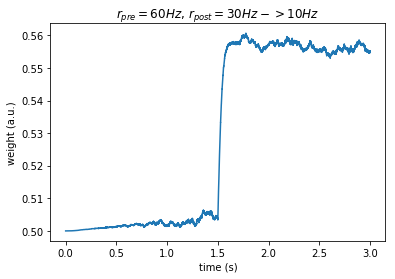

In [3]:
plt.plot(w_mon.t/second,mean(w_mon.w.T,1))
plt.xlabel('time (s)')
plt.ylabel('weight (a.u.)')
plt.title(r'$r_{pre}=%dHz$, $r_{post}=%dHz->%dHz$'%(rpre,rpost1,rpost2))
plt.show()
